# Reproduce the results of the muscle regeneration of mouses

## 1. import packages

In [1]:
import os
import re
import sys

import matplotlib.pyplot as plt
import matplotlib.colors as mc
import numpy as np
import seaborn as sns

In [2]:
from tqdm.notebook import tqdm

In [3]:
sys.path.append('../')
import gdnb

In [4]:
# set default plot style
gdnb.set_default_style()

## 2. preprocess the gene expression data

### 2.1 read raw data

In [5]:
data_path = gdnb.load_muscle(preprocess=False)

In [6]:
# read raw data, the expr data will be transformed by logarithm
def read_raw_data(data_path):
    """ analysis the raw expression data."""
    probes = []
    names = []
    exprs = []
    with open(data_path, 'r') as f:
        f.readline()
        f.readline()
        for line in f.readlines():
            data = line.split('\t')
            probe = data[0]
            name = data[1]
            expr = np.array([np.log2(float(x)) for x in data[2:]])
            probes.append(probe)
            names.append(name)
            exprs.append(expr)
    return np.array(probes), np.array(names), np.array(exprs)

In [7]:
probes, names, exprs = read_raw_data(data_path)

In [8]:
tmp_expr = np.apply_along_axis(gdnb.normalize_by_zscore, 1, exprs)
tmp_expr = tmp_expr.clip(-2, 2)
half_sum = np.sum(tmp_expr[:, :27], axis=1)
idx_sort = np.argsort(half_sum)

In [9]:
def plot_expr(expr):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax = sns.heatmap(expr, cmap='bwr')
    ax.set_xticks([])
    ax.set_xlabel('Time(day)')
    ax.set_yticks([])
    ax.set_ylabel('Genes')
    return fig, ax

In [11]:
result_dir = 'results/muscle/'

if not os.path.exists(result_dir):
    os.makedirs(result_dir)

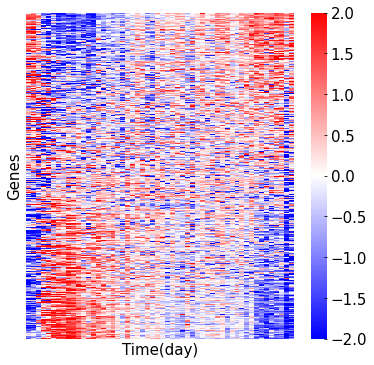

In [13]:
fig, ax = plot_expr(tmp_expr[idx_sort])
# plt.savefig(f'{result_dir}expr.png', dpi=300, format='png')

### 2.2 filter out genes without gene symbols

In [14]:
# records without proper gene symbols will be discard.
use_index = []
for name in names:
    if re.match('.*///.*', name) or not re.match('^[A-Z].*', name):
        use_index.append(False)
    else:
        use_index.append(True)
        
probes, names, exprs = [obj[use_index] for obj in [probes, names, exprs]]

### 2.3 filter out genes with extremely low expression

In [15]:
means = np.mean(exprs, axis=1)

In [18]:
def plot_mean_dist(means):
    fig, ax = plt.subplots()
    sns.histplot(means, ax=ax, stat='probability')
    ax.set_xlabel('Mean')
    ax.set_ylabel('Probability')
    fig.tight_layout()
    return fig, ax

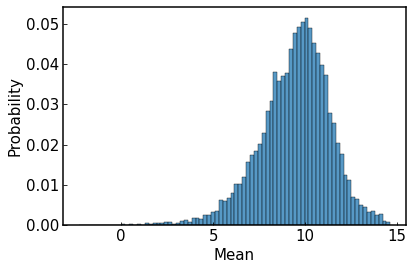

In [19]:
# distribution of the average expression of genes
fig, ax = plot_mean_dist(means)
# plt.savefig(f'{result_dir}mean_dist.png', dpi=300)

In [20]:
# there are genes whose expression value are very small, they will be discarded.
mean_cut = 7
c = np.where(means > mean_cut)
probes, names, exprs = [obj[c] for obj in [probes, names, exprs]]

### 2.4 before starting GDNB, normalize the expression data

In [21]:
exprs = np.apply_along_axis(gdnb.normalize_by_mean, 1, exprs)

In [26]:
exprs= np.array([exprs[:, 2 * i: 2 * i + 6] for i in range(25)])

In [27]:
## above procedures 2.1-2.4 can be integrated into one step
# probes, names, exprs = gdnb.load_muscle(preprocess=True)

## 3. applicate GDNB to the expression data

In [28]:
mydata = gdnb.GDNBData(exprs)

Read the input data ...
The input data shape is: 25 x 10123 x 6
Number of windows: 25
Number of variables: 10123
Number of samples: 6

The next step is fitting data by .fit()


In [29]:
mydata.fit(std_top=500, pcc_cut=0.02, pbar_mode=tqdm)

fitting data using GDNB method ...
step 1: select the variables with high fluctuation ...



step 2: cluster selected variables ...



step 3: find the giant component (largest cluster) ...



fitting Done

--------------- Results Summary ---------------
number of variables in each largest cluster for each window:
[414, 342, 412, 363, 340, 327, 376, 278, 303, 233, 164, 212, 166, 122, 173, 290, 261, 206, 146, 77, 22, 352, 287, 15, 286]

average PCC of each largest cluster for each window:
[0.8817587717313762, 0.7665279213586143, 0.8023640873098931, 0.8579604476710674, 0.7217663583940247, 0.8179571039010513, 0.8632271598411505, 0.8668735026849216, 0.8383716249743446, 0.7607694115789401, 0.7502672545244973, 0.8663299592983942, 0.780029303320318, 0.8414928805936562, 0.9139487018578061, 0.6274143591914353, 0.6859369161591559, 0.8836888302393773, 0.7663665920618465, 0.8451933790210754, 0.9392465917244716, 0.8876568609469688, 0.8734554549808734, 0.9410433671067702, 0.7370699853118707]

average STD of each largest cluster for each window:
[0.1663929982742345, 0.1155725552386228, 0.11947316807090665, 0.08894980121353907, 0.06884436163879196, 0.07367930182760699, 0.07423582787467284,

D:\Anaconda3\lib\site-packages\seaborn\matrix.py:800: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self.fig = plt.figure(figsize=figsize)


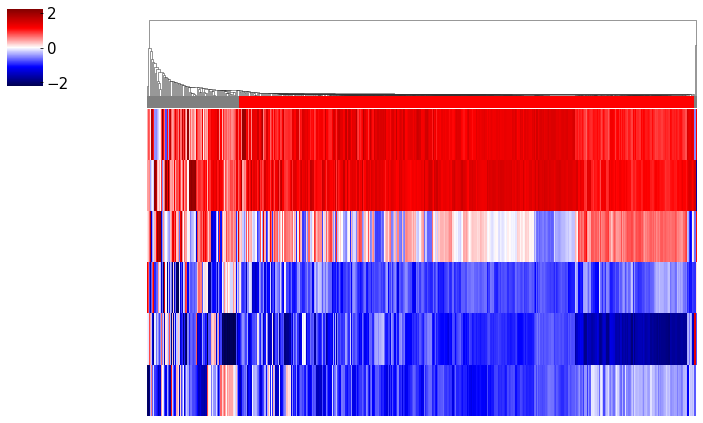

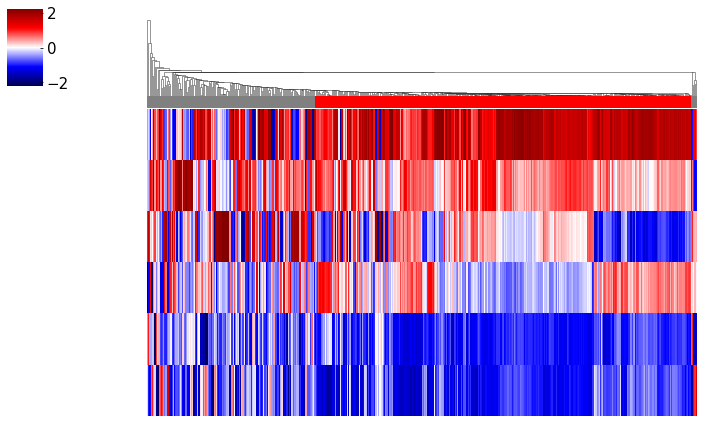

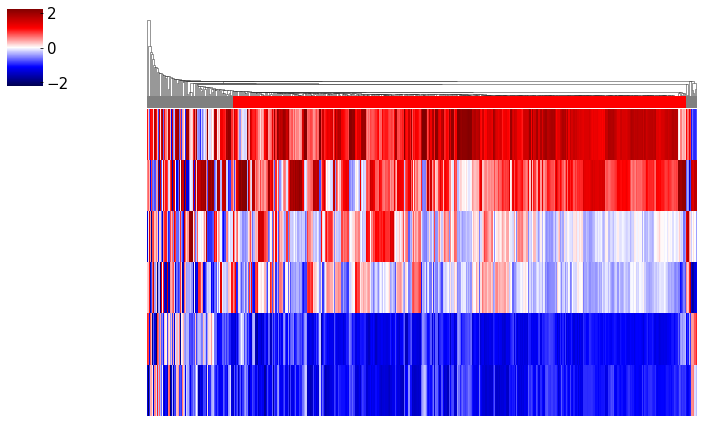

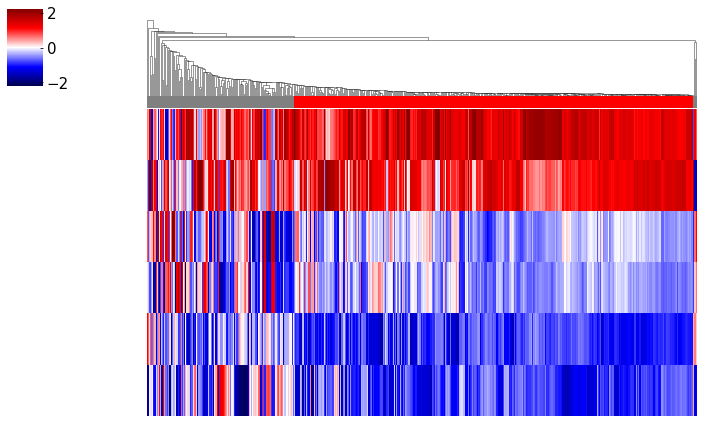

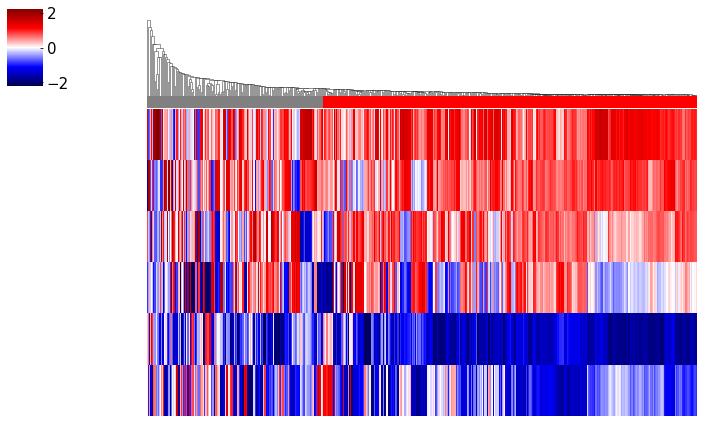

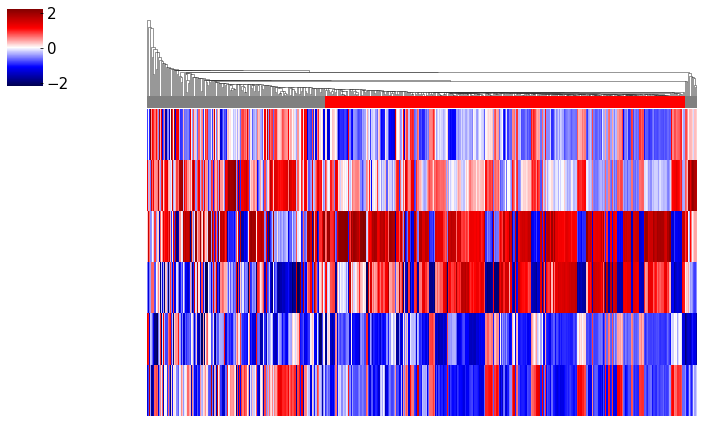

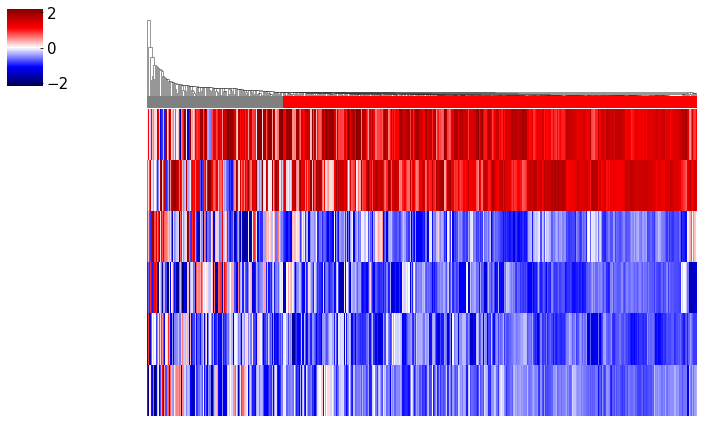

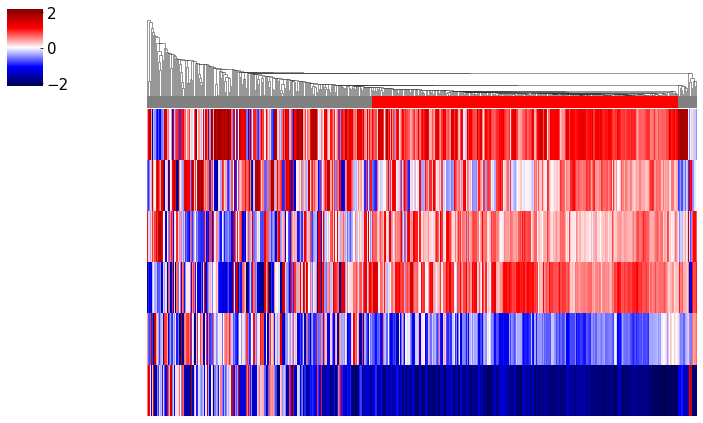

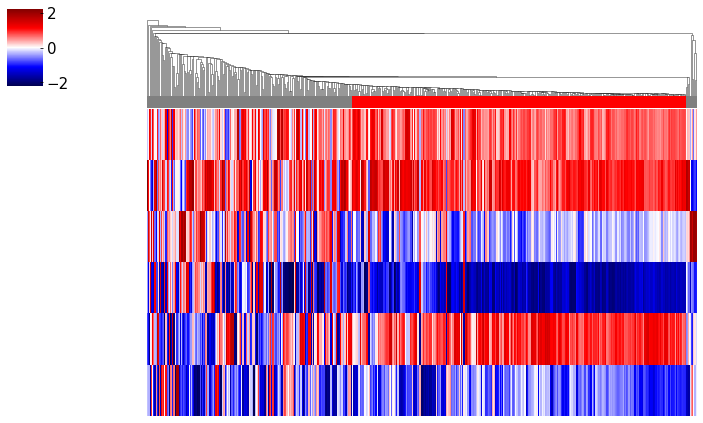

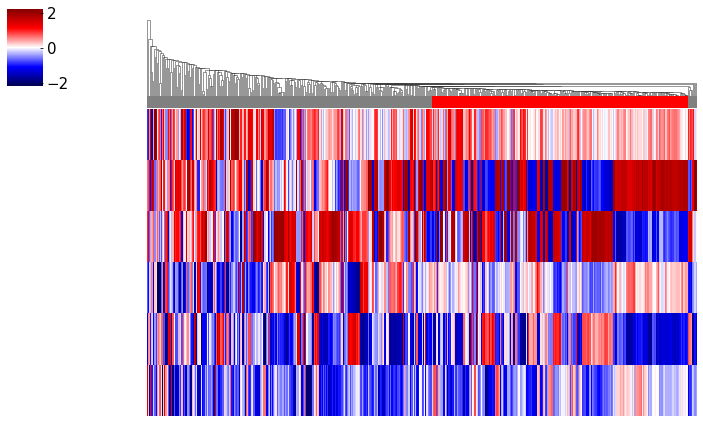

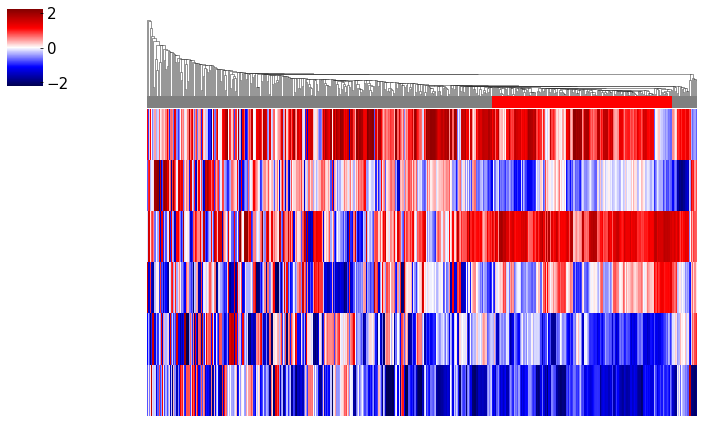

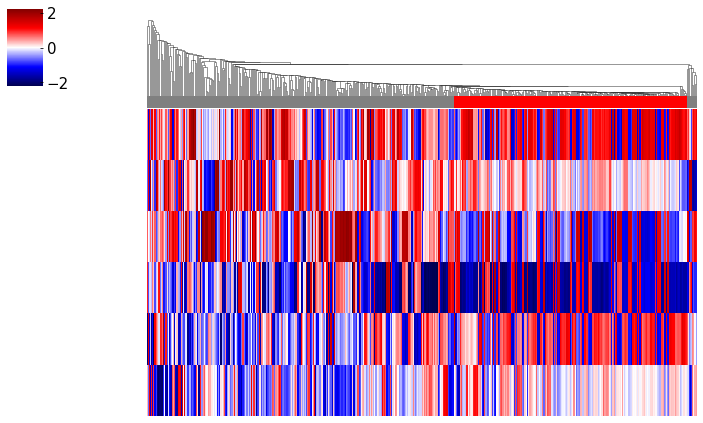

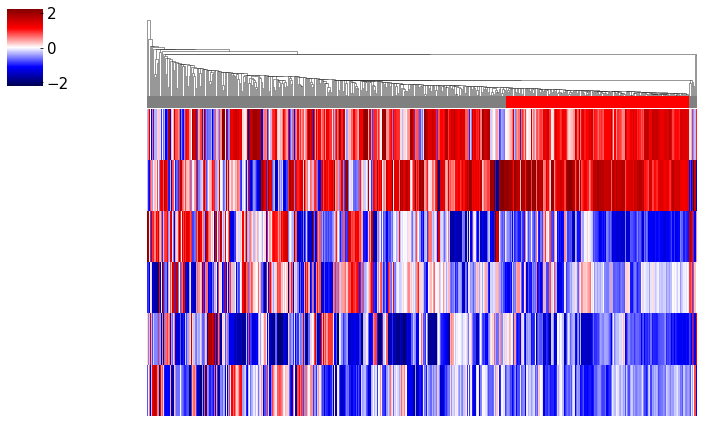

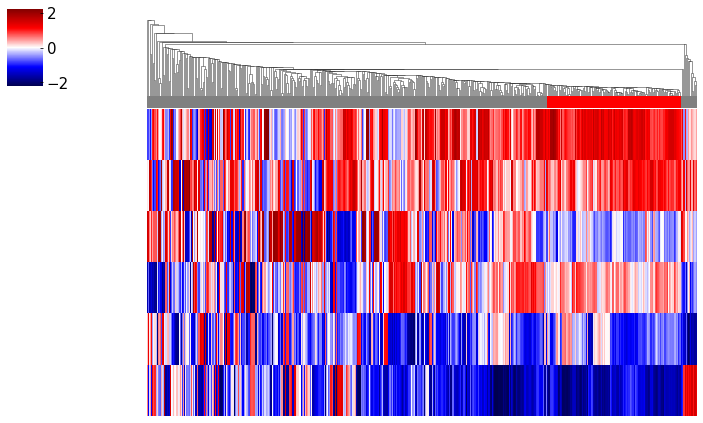

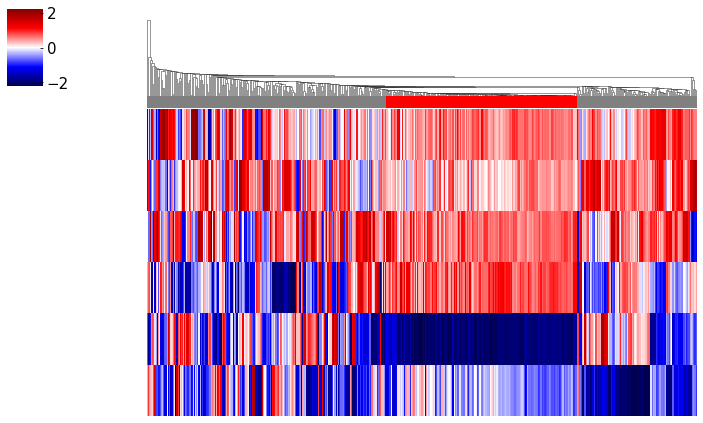

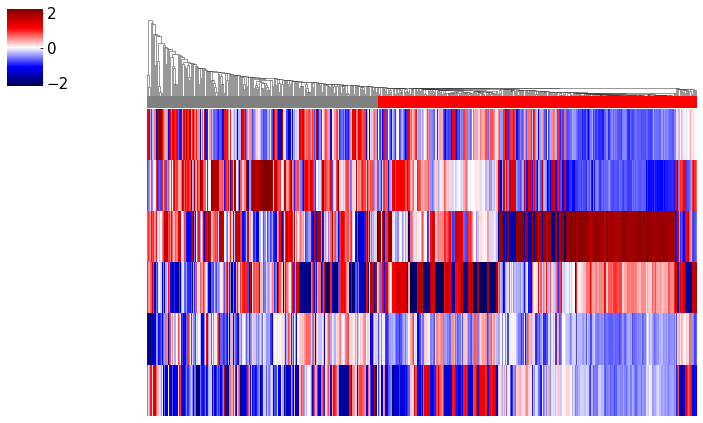

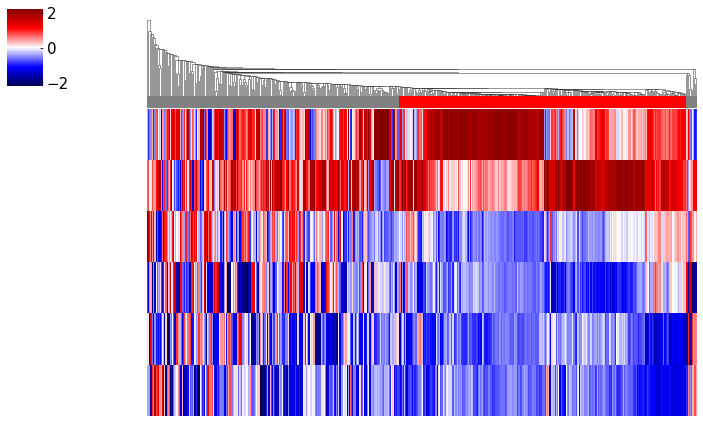

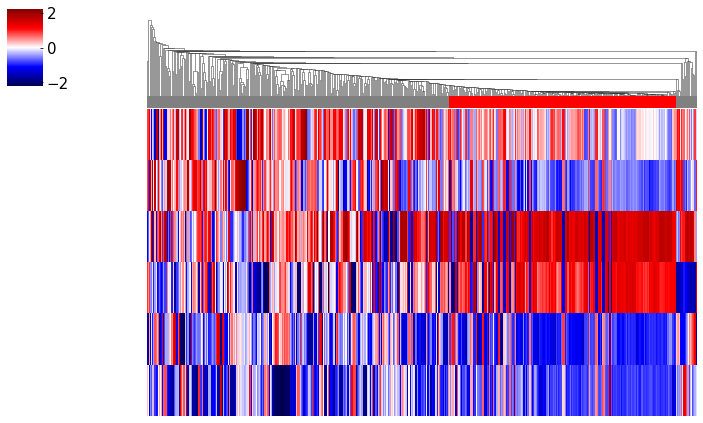

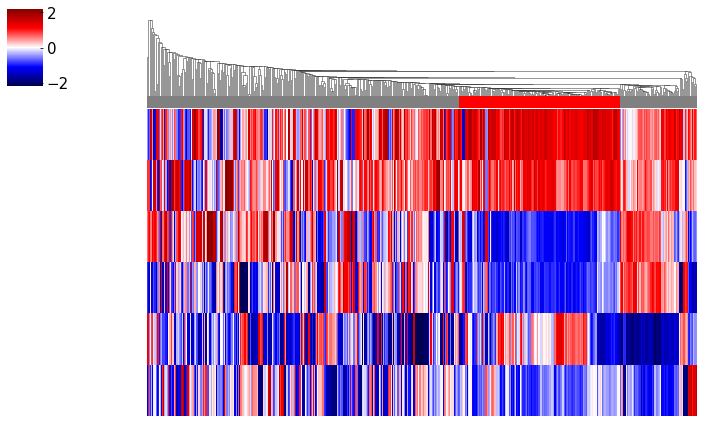

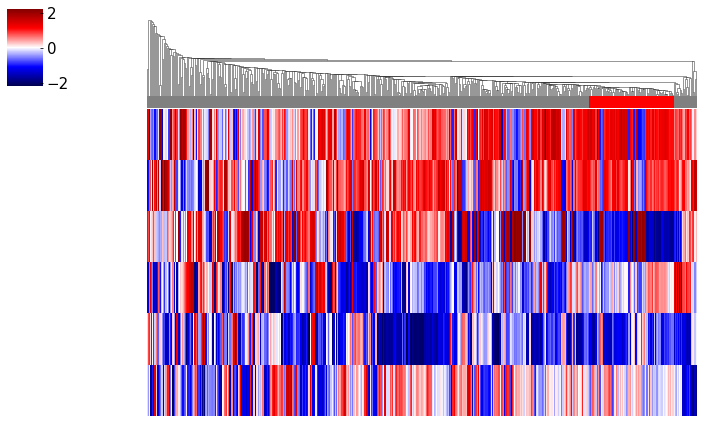

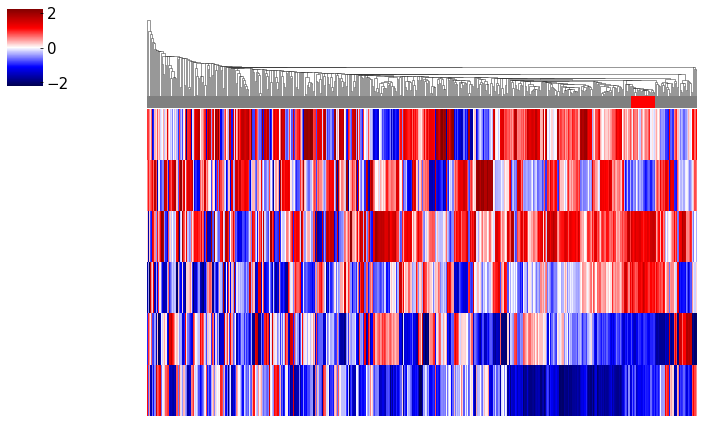

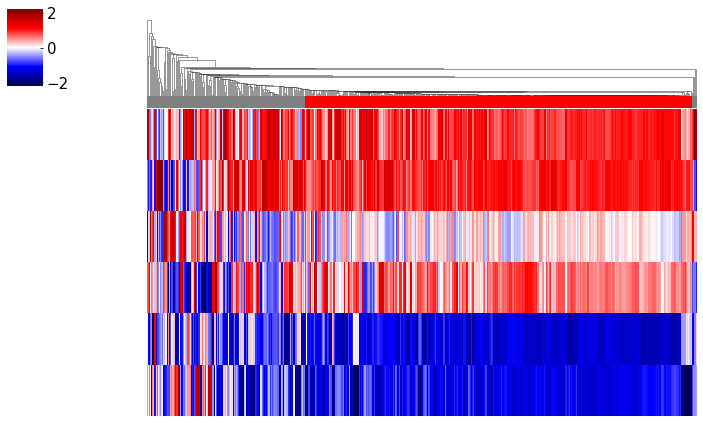

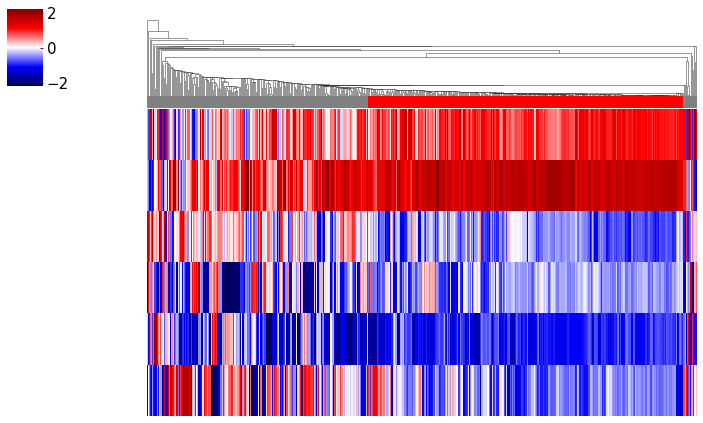

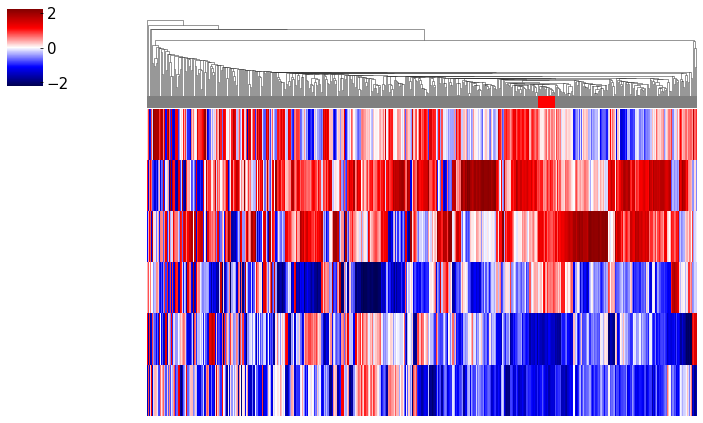

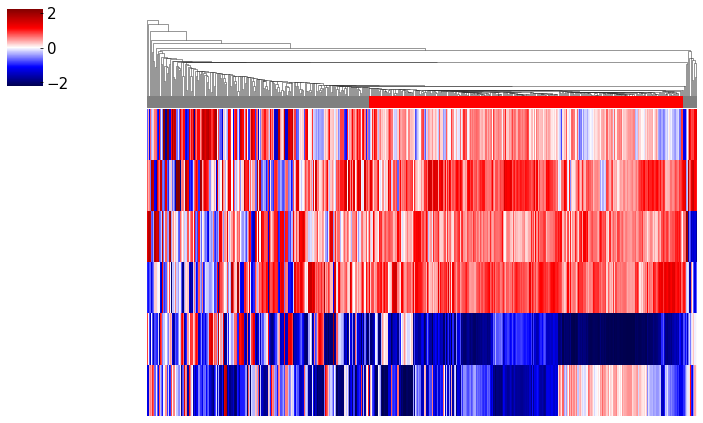

In [30]:
gs = mydata.plot_clusters(savefig=False, fig_path=result_dir)

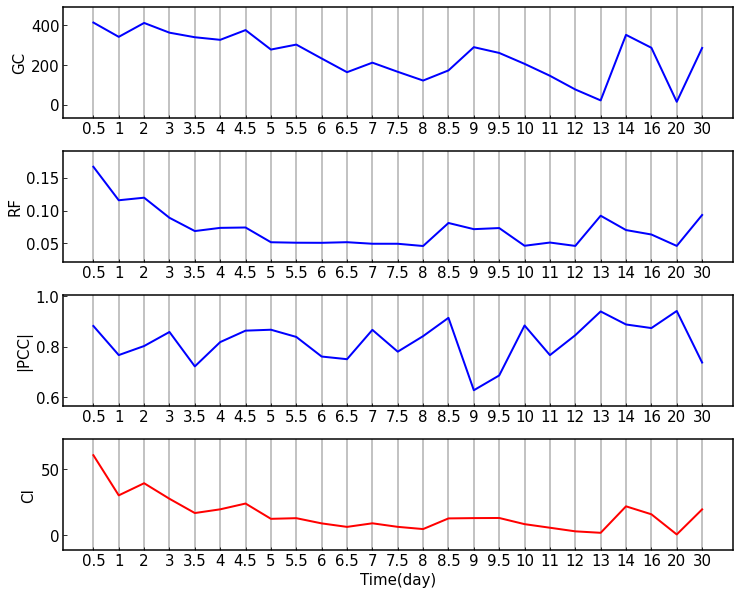

In [31]:
date = [0, 0.5, 1, 2, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5,
        7, 7.5, 8, 8.5, 9, 9.5, 10, 11, 12, 13, 14,
        16, 20, 30, 40]
fig, ax = mydata.plot_index(figsize=(12, 10), hspace=0.3, xlabel='Time(day)', xticks=range(25), 
                            xticklabels=date[1:-1], grid_x=True)
# plt.savefig(f'{result_dir}four_index.svg', dpi=300, format='svg')

## 4. validate the GDNB results

## 4.1 check the existence of the key genes

In [33]:
def check_existence(names, cores=['Myod1','Myog','Myf5','Mstn']):
    ans=[]
    for i in cores:
        if i in names:
            ans.append(1)
        else:
            ans.append(0)
    return ans

def plot_existence(data, names, figsize=(8, 4), clist=['wheat', 'green']):
    ticks = [0.5, 1, 2, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 
             7, 7.5, 8, 8.5, 9, 9.5, 10, 11, 12, 13, 14,
             16, 20, 30]
    ans_mat = []
    for i in range(data.m):
        ans = check_existence(names[data.largest_cls[i]])
        ans_mat.append(ans)
    ans_mat = np.array(ans_mat)

    cmap = mc.ListedColormap(clist)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(ans_mat.T, ax=ax, cbar=False, linewidths=0.2,
                cmap=cmap, xticklabels=ticks) 
    ax.set_yticklabels(['Myod','Myog','Myf5','Mstn'],
                       fontdict={'verticalalignment': 'center'})
    ax.set_xlabel('Time(day)')
    fig.tight_layout()
    return fig, ax

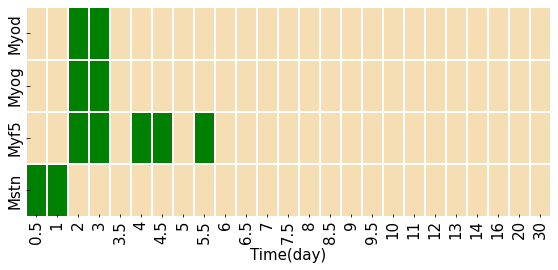

In [34]:
fig, ax = plot_existence(mydata, names)
# plt.savefig(f'{result_dir}existence.png', dpi=300)

## 4.2 GO enrichment analysis

In [35]:
# the gene list in the giant component of the first window
print(names[mydata.largest_cls[0]])

['Clec4d' 'Arg1' 'Il1b' 'Soat1' 'Cxcl5' 'Lcn2' 'Ccl2' 'Il1r2' 'S100a8'
 'Sphk1' 'Il6' 'S100a9' 'Cxcl1' 'Ncf2' 'Hdc' 'Ccr5' 'Ngp' 'Angptl4' 'Ccr1'
 'Slfn4' 'Ccl7' 'Il1rn' 'Fpr2' 'Il1r2' 'Clec4e' 'Gp49a' 'Itgam' 'Cxcl1'
 'Mmp3' 'Il13ra1' 'Slpi' 'Clec4a2' 'Atp5j2' 'Cd53' 'Map2k6' 'Irg1' 'F10'
 'Chi3l3' 'Plaur' 'Rrad' 'Slfn2' 'Ptpn6' 'Mlf1' 'Ankrd1' 'Lcp1' 'Myc'
 'Slfn1' 'Saa3' 'Ptprc' 'Mmp9' 'Coro1a' 'Ccr2' 'Socs3' 'Cytip' 'Ncf4'
 'Sgcg' 'Csf3r' 'Ifitm6' 'Hmgcr' 'Cks2' 'Ptprc' 'Icam1' 'Pira1' 'Csf3r'
 'Arg2' 'Lcp1' 'Basp1' 'Ccl9' 'Cotl1' 'Itgb2' 'Il1rl1' 'Slc11a1' 'Dbp'
 'Arhgap9' 'Spp1' 'Srxn1' 'Cxcr4' 'Atf3' 'Cytip' 'Tlr6' 'Il4ra' 'Egf'
 'Cd52' 'Srgn' 'Thbd' 'Serpina3n' 'Msr1' 'Pde4dip' 'Selplg' 'Thbs1'
 'Edem1' 'Fcgr2b' 'Fam105a' 'Pstpip1' 'Lgals3' 'Cmbl' 'Sh3bgr' 'Hck'
 'Tcea3' 'Serpine1' 'Ank1' 'Fhod3' 'Pfkfb1' 'Phkg1' 'Fxyd5' 'Trim30a'
 'Aqp4' 'Atp1b1' 'Fcer1g' 'Apbb1ip' 'Il17ra' 'Evi2a' 'Sfpi1' 'Sdcbp'
 'Hmga2' 'Tyrobp' 'Cox8b' 'Vav1' 'Plac8' 'Fcgr1' 'Phka1' 'Pdpn' 'Pfkp'
 'Tgif1' 

**Note:** Since the GO enrichment analysis is more easy to perform in R (eg, clusterProfiler), we saved the gene list in each giant component and conducted the analysis in R (see GO.R in the `results/muscle` directory).

In [37]:
for i in range(25):
    np.savetxt(f'{result_dir}core{i+1}.txt', names[mydata.largest_cls[i]], fmt='%s')